# Content
- Import Library
- Data Load

## Import Library

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## Data Load

In [2]:
train_path = '../../data/train.csv'
test_path  = '../../data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

## EDA

`제거할 Features`
- '해제사유발생일', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자' <- 결측치가 100 만개 이상인 변수들 (90% 이상) 
- 'k-전화번호', 'k-팩스번호', 'k-관리방식', 'k-복도유형', 'k-시행사', 'k-사용검사일-사용승인일', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일' - 뇌피셜 필요없어보이는 변수
- '관리비부과면적', '주차대수', '건축면적' - 면적 관련 비슷해 보이는 feature 삭제

In [3]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
# 데이터를 동일하게 처리해주기 유용함.
dt['is_test'] = 0
dt_test['is_test'] = 1
df = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [4]:
# 면적 관련 데이터의 cardinality 계산 후 제외할 feature 선청
면적관련 = dt[['전용면적(㎡)', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적','k-전체세대수', 'k-전체동수', '건축면적', '주차대수']]
for col in 면적관련.columns:
    print(f"{col}'s Unique data size: ", 면적관련[col].unique().size)

전용면적(㎡)'s Unique data size:  14617
k-연면적's Unique data size:  735
k-주거전용면적's Unique data size:  740
k-관리비부과면적's Unique data size:  736
k-전체세대수's Unique data size:  522
k-전체동수's Unique data size:  42
건축면적's Unique data size:  456
주차대수's Unique data size:  527


In [5]:
# Null값이 100만개 이상인 칼럼은 삭제
drop_columns = df.columns[df.isnull().sum() >= 1000000]
print('* 결측치가 100만개 이상인 변수들 :', list(df.columns[df.isnull().sum() >= 1000000]))

* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


In [6]:
drop_col = ['k-전화번호', 'k-팩스번호', 'k-관리방식', 'k-복도유형', 'k-시행사', 'k-사용검사일-사용승인일', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', 'k-관리비부과면적', '주차대수', '건축면적', '해제사유발생일', '단지소개기존clob', 'k-135㎡초과']

In [7]:
df.drop(drop_col, axis=1, inplace=True)
print(df.shape)
display(df.head())

(1128094, 29)


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,k-건설사(시공사),k-연면적,k-주거전용면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,좌표X,좌표Y,target,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,우성건설,22637.0,20204.0,20.0,250.0,0.0,127.05721,37.476763,124000.0,0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,우성건설,22637.0,20204.0,20.0,250.0,0.0,127.05721,37.476763,123500.0,0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,우성건설,22637.0,20204.0,20.0,250.0,0.0,127.05721,37.476763,91500.0,0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,우성건설,22637.0,20204.0,20.0,250.0,0.0,127.05721,37.476763,130000.0,0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,우성건설,22637.0,20204.0,20.0,250.0,0.0,127.05721,37.476763,117000.0,0


In [8]:
df.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-연면적', 'k-주거전용면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '좌표X',
       '좌표Y', 'target', 'is_test'],
      dtype='object')

`시각화 분석`
- 시군구, 구, 동별 아파트 가격 분포 분석
- 면적, 층, 건축년도별 아파트 가격 변화 분석
- 거래 유형 (매매, 전세, 임대)별 가격 비교 분석
- 시기별 (계약년월, 계약일) 아파트 가격 변동 추세 분석

In [9]:
df['구'] = df['시군구'].apply(lambda x:x.split()[1])
df['동'] = df['시군구'].apply(lambda x:x.split()[2])

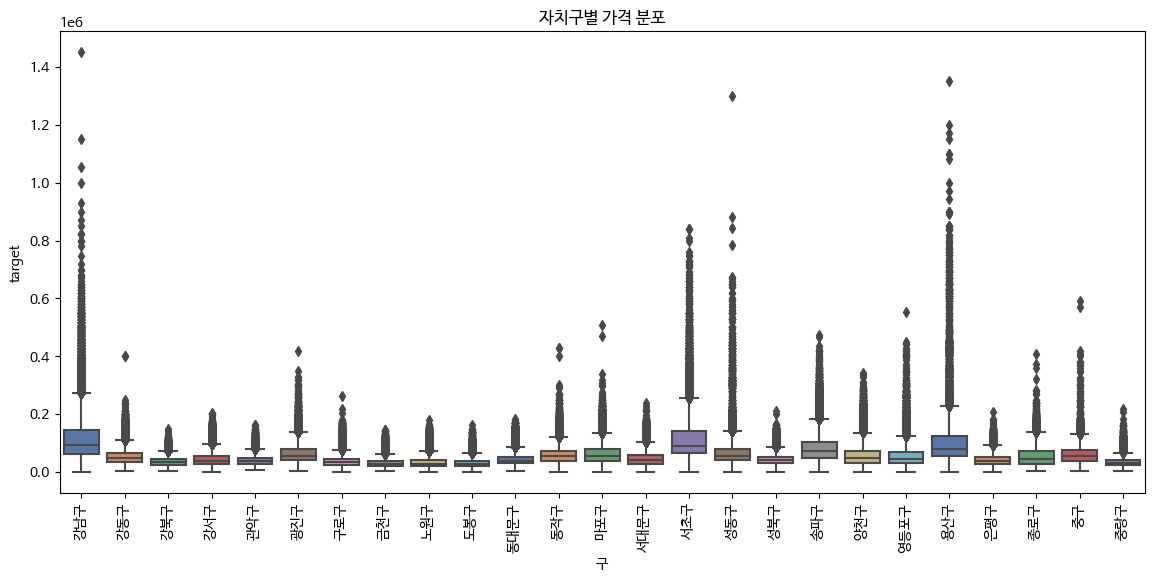

In [10]:
plt.figure(figsize=(14,6))
sns.boxplot(x='구', y='target', data=df, palette="deep")

plt.xticks(rotation=90)
plt.title('자치구별 가격 분포')
plt.show()

In [11]:
df_group = df.groupby('구').agg(std_dev=pd.NamedAgg(column='target', aggfunc='std'),
                                median=pd.NamedAgg(column='target', aggfunc='median'),
                                mean=pd.NamedAgg(column='target', aggfunc='mean')).reset_index()
df_group.sort_values(by='std_dev', ascending=False).head(7)

# '용산구', '강남구', '서초구', '송파구', '성동구', '종로구' - 아파트 가격 평균에 미해 표준편차가 큰 곳

,구,std_dev,median,mean
20,용산구,90148.440633,81000.0,105876.961900
0,강남구,78572.045476,93000.0,114847.461503
14,서초구,74485.257724,92000.0,113608.653390
17,송파구,47626.592378,72000.0,83868.032920
15,성동구,45378.104410,57000.0,68924.389400
22,종로구,41036.478979,47500.0,57674.032963
18,양천구,37811.589121,48900.0,59042.132927


In [15]:
omg = ['용산구', '강남구', '서초구', '송파구', '성동구', '종로구']
is_omg = []
for x in df['구'].tolist():
    if x in omg:
        is_omg.append(1)
    else:
        is_omg.append(0)
df['개비싸'] = is_omg
# 이렇게 말고 '동' 을 분류하지 않아도 될듯       
df.loc[~df['구'].isin(omg), '동'] = 'Unknown' 

In [16]:
del df['시군구']
del df['부번'] # 부번까지는 필요없어보임.
del df['계약일'] # 일자는 빼자.

In [17]:
df.columns

Index(['번지', '본번', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', '등기신청일자',
       '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-난방방식',
       'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-연면적', 'k-주거전용면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '좌표X',
       '좌표Y', 'target', 'is_test', '구', '동', '개비싸'],
      dtype='object')

## Data Preprocessing

In [18]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
df['등기신청일자'] = df['등기신청일자'].replace(' ', np.nan)
df['거래유형'] = df['거래유형'].replace('-', np.nan)
df['중개사소재지'] = df['중개사소재지'].replace('-', np.nan)

In [19]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
df['본번'] = df['본번'].astype('str')
# concat_select['부번'] = concat_select['부번'].astype('str')

In [20]:
df['계약년'] = df['계약년월'].astype('str').map(lambda x : x[:4])
df['계약월'] = df['계약년월'].astype('str').map(lambda x : x[4:])
del df['계약년월']

In [21]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '좌표X', '좌표Y', 'target', 'is_test', '개비싸']
범주형 변수: ['번지', '본번', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-난방방식', 'k-건설사(시공사)', '구', '동', '계약년', '계약월']


In [22]:
df[continuous_columns].isnull().sum()

전용면적(㎡)                        0
층                              0
건축년도                           0
k-전체동수                    877207
k-전체세대수                   876125
k-연면적                     876125
k-주거전용면적                  876170
k-전용면적별세대현황(60㎡이하)        876170
k-전용면적별세대현황(60㎡~85㎡이하)    876170
k-85㎡~135㎡이하              876170
좌표X                       876232
좌표Y                       876232
target                      9272
is_test                        0
개비싸                            0
dtype: int64

In [23]:
# 수치형 데이터를 어떻게 채워야 될지 모르겠음 -> 걍 빼.
# 좌표X, 좌표Y 를 리니어로 채우는건 혼동을 줄 수 있는 데이터임
df.drop(columns=['k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '좌표X', '좌표Y'], inplace=True)

In [28]:
# 범주형 변수에 대한 보간
df[categorical_columns] = df[categorical_columns].fillna('NULL')

## Model Training

In [30]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(1118822, 20) (9272, 20)


In [32]:
df_test.head()

,번지,본번,아파트명,전용면적(㎡),층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-난방방식,k-건설사(시공사),target,구,동,개비싸,계약년,계약월
0,658-1,658.0,개포6차우성,79.9700,5,1987,언주로 3,NULL,직거래,NULL,아파트,분양,개별난방,우성건설,NaN,강남구,강남구,1,2023,07
1,651-1,651.0,개포더샵트리에,108.2017,10,2021,개포로 311,NULL,중개거래,서울 강남구,아파트,분양,지역난방,포스코,NaN,강남구,강남구,1,2023,08
2,652,652.0,개포우성3차,161.0000,15,1984,개포로 307,NULL,중개거래,서울 강남구,아파트,분양,지역난방,우성건설,NaN,강남구,강남구,1,2023,07
3,652,652.0,개포우성3차,133.4600,14,1984,개포로 307,NULL,중개거래,서울 강남구,아파트,분양,지역난방,우성건설,NaN,강남구,강남구,1,2023,08
4,652,652.0,개포우성3차,104.4300,6,1984,개포로 307,NULL,중개거래,서울 강남구,아파트,분양,지역난방,우성건설,NaN,강남구,강남구,1,2023,08


In [33]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
df_test['target'] = 0

### 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

## 

In [35]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적(㎡)', '층', '건축년도', 'target', '개비싸']
범주형 변수: ['번지', '본번', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-난방방식', 'k-건설사(시공사)', '구', '동', '계약년', '계약월']


In [36]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


In [38]:
df_train.head()        # 레이블인코딩이 된 모습입니다.

,번지,본번,아파트명,전용면적(㎡),층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-난방방식,k-건설사(시공사),target,구,동,개비싸,계약년,계약월
0,4732,1149,328,79.97,3,1987,6176,181,0,0,3,2,1,241,124000.0,0,1,1,10,11
1,4732,1149,328,79.97,4,1987,6176,181,0,0,3,2,1,241,123500.0,0,1,1,10,11
2,4732,1149,328,54.98,5,1987,6176,181,0,0,3,2,1,241,91500.0,0,1,1,10,11
3,4732,1149,328,79.97,4,1987,6176,181,0,0,3,2,1,241,130000.0,0,1,1,11,0
4,4732,1149,328,79.97,2,1987,6176,181,0,0,3,2,1,241,117000.0,0,1,1,11,0


### Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 RandomForest를 이용하겠습니다.
- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
  - 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

In [40]:
assert df_train.shape[1] == df_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [42]:
# Target과 독립변수들을 분리해줍니다.
y_train = df_train['target']
X_train = df_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [43]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [44]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 7768.453499402959


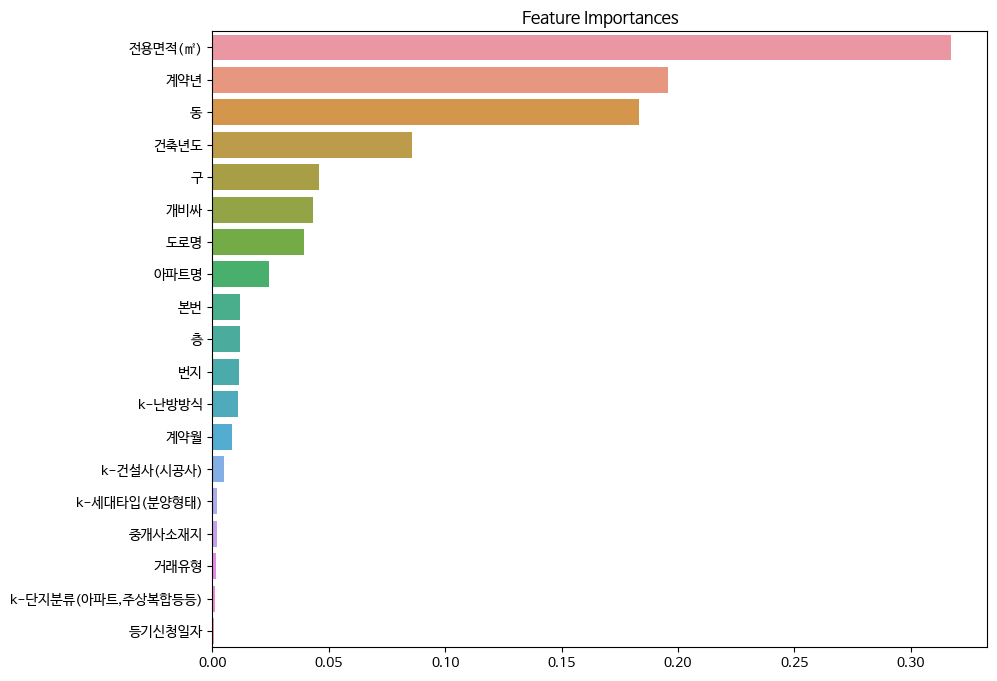

In [45]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [57]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### Feature selection
- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [46]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = 'neg_mean_squared_error',        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
1359212428.8854 ± 18408952.6628,전용면적(㎡)
1057312607.0919 ± 18309713.9545,계약년
704440916.7986 ± 7710728.8499,동
484942140.2617 ± 14461825.2244,건축년도
291898801.9832 ± 3110579.4992,구
207960502.8236 ± 4549828.9929,도로명
118711606.6570 ± 377680.3002,아파트명
54500952.9718 ± 734364.4621,k-난방방식
50369799.0941 ± 1368161.4560,개비싸
42814041.5245 ± 433552.6141,번지


- 분석 결과 "전용면적", "계약년" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### Valid prediction 분석
- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [47]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [48]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [49]:

# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [50]:
X_val_sort.head()

,번지,본번,아파트명,전용면적(㎡),층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,...,k-난방방식,k-건설사(시공사),구,동,개비싸,계약년,계약월,target,pred,error
241238,745,222,112,273.96,14,2020,5895,181,0,0,...,0,73,0,1,1,14,2,1150000.0,743400.0,1.653236e+11
224567,745,222,112,273.96,16,2020,5895,181,2,0,...,0,73,0,1,1,15,3,1450000.0,1051442.0,1.588485e+11
221950,3113,826,1848,227.37,2,2019,8780,138,1,558,...,0,73,20,5,1,16,5,465000.0,855000.0,1.521000e+11
224631,469,120,5383,204.96,5,1997,5889,181,1,296,...,0,73,0,1,1,14,10,338000.0,665800.0,1.074528e+11
296238,3737,921,4034,244.69,48,2004,6209,181,0,0,...,0,73,0,1,1,12,11,300000.0,622000.0,1.036840e+11


In [51]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [52]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [53]:
display(error_top100.head(1))
display(best_top100.head(1))

,번지,본번,아파트명,전용면적(㎡),층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,...,k-난방방식,k-건설사(시공사),구,동,개비싸,계약년,계약월,target,pred,error
241238,129,129.0,PH129,273.96,14,2020,압구정로79길 88,NULL,NULL,NULL,...,NULL,NULL,강남구,강남구,1,2021,03,1150000.0,743400.0,1.653236e+11


,번지,본번,아파트명,전용면적(㎡),층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,...,k-난방방식,k-건설사(시공사),구,동,개비싸,계약년,계약월,target,pred,error
267599,183-26,183.0,드림캐슬타워,15.598,11,2021,상도로 164,NULL,NULL,NULL,...,NULL,NULL,동작구,Unknown,0,2021,05,77068.0,77068.0,0.0


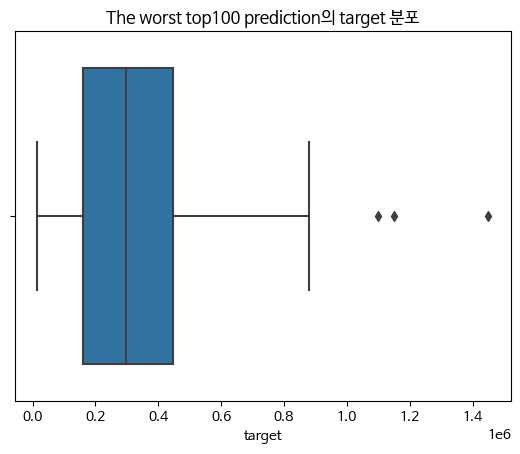

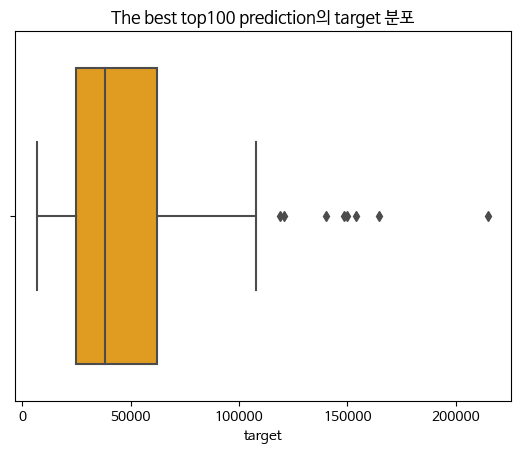

In [54]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

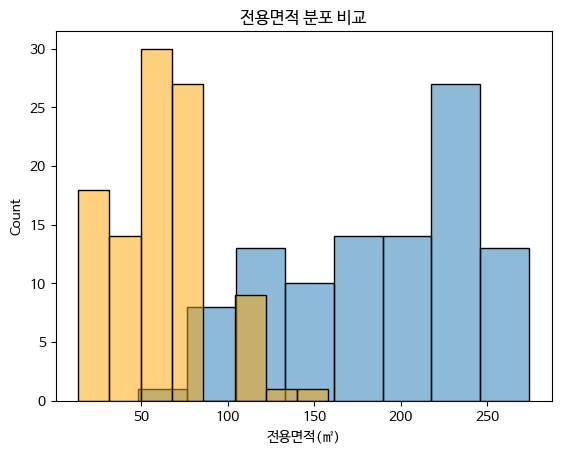

In [56]:
sns.histplot(data = error_top100, x='전용면적(㎡)', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적(㎡)', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

## 6. Inference

In [61]:
df_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,번지,본번,아파트명,전용면적(㎡),층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-난방방식,k-건설사(시공사),target,구,동,개비싸,계약년,계약월
0,4732,1149,328,79.9700,5,1987,6176,181,2,0,3,2,1,241,NaN,0,1,1,16,6
1,4707,1142,329,108.2017,10,2021,469,181,1,296,3,2,4,289,NaN,0,1,1,16,7


In [62]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [64]:
%%time
X_test = df_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 20.9 ms, sys: 4.07 ms, total: 25 ms
Wall time: 18 ms


In [65]:
real_test_pred

array([202200., 317500., 348600., ..., 103200.,  71900.,  74800.])

## Output File Save

In [66]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

`이후 해보아야 할 것들`
- 데이터셋 분할 시도 - holdout 시간순, Time series split, Time series split 응용1, Time series split 응용 2
- Model XGBoost, LightGBM 사용해보기